# Damage model 
The original model is 

\begin{equation}\label{eq: original model}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}
\end{equation}



# Smooth function

Note that we have the indicator function in the model we might consider the smooth function:
\begin{equation}\label{eq: trans function}
S(x;s) = \frac{1}{1 + \exp(-s \cdot x)}
\end{equation},
where $s$ is the smoothing hyper-parameter to control the smoothness. 

Then the model becomes 
$$
y^*  = y \cdot \frac{1}{1 + \exp(-s\cdot(cy-l))} + \alpha \cdot y \cdot \frac{1}{1 + \exp(-s\cdot(l-cy))}
$$

We have $y \geq y^*$.

The lumber have three groups:

- Group 1: $y <l$, $y^* < l$, i.e., $y^* <y < l$. The lumber pieces are broken blow the proof loading.
- Group 2: $y >l$, $y^* < l$, i.e. $y^*<l<y$. The lumber pieces are broken during the proof loading process. This groups we only knows how many pieces. 
- Group 3: $y >l$, $y^* > l$, i.e. $l<y^*<y$. The lumber pieces survived in the proof-loading. And then we destruct them to test their strength.


# The PDF calculation 

Given $Y \sim N(\mu, \sigma^2)$, $Y^* = h(Y)$. Then the pdf of $Y^*$,
$$
f_{Y^*}(y^*) = f_{Y}(h^{-1}(y^*))|\frac{d}{dy^*}h^{-1}(y^*)|,
$$
where $f_Y()$ is the pdf of $Y$, i.e., normal. 

Following this, We need the numerical function of $h^{-1}(y^*)$, and its numerical gradient $\frac{d}{dy^*}h^{-1}(y^*)$. (The analytical form doesn't seem available.)

In [2]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
@jax.jit


def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))




def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_py(y,alpha,l,c,s):
    y = jnp.array(y)
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    ystar = jnp.array(ystar)
    bisec = jaxopt.Bisection(
        optimality_fun=dmgmodel_root_py,
        lower = 0,
        upper = 10000,
        check_bracket = False)
    return(bisec.run(alpha = alpha,l = l, c= c ,s = s,ystar = ystar).params)

def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
    y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



In [4]:
# # # read data 

# y_obs_g1 = pyreadr.read_r('y_obs_g1.Rds') # also works for RData
# y_obs_g1 = jnp.array(y_obs_g1[None])
# len_g1 = jnp.shape(y_obs_g1)[0]
# y_obs_g1 = jnp.reshape(y_obs_g1,newshape = (len_g1,))

# y_obs_g2 = pyreadr.read_r('y_obs_g2.Rds') # also works for RData
# y_obs_g2 = jnp.array(y_obs_g2[None])
# y_obs_g2 = y_obs_g2[0][0]

# y_obs_g3 = pyreadr.read_r('y_obs_g3.Rds') # also works for RData
# y_obs_g3 = jnp.array(y_obs_g3[None])
# len_g3 = jnp.shape(y_obs_g3)[0]

# y_obs_g3 = jnp.reshape(y_obs_g3,newshape = (len_g3,))
# y_obs_g3






In [142]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.25
c = 0.65
s = 10

N_marginal = 139





In [155]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[10], shape=(N, )) + mu

#y = y[y>0]

# g1
y_obs_g1  = y[y<l]


# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(g23)


# g3
y_obs_g3 = g23_star[g23_star > l]

# g2
y_obs_g2 = N - len(y_obs_g1) - len(y_obs_g3)

#y_obs_g2 = jnp.shape(y)[0] - len(y_obs_g1) - len(y_obs_g3)

# g4, is all marginal data
y_obs_g4 = sigma*jax.random.normal(subkeys[0], shape=(N_marginal, )) + mu

In [156]:
# negdmglik_jax(theta0)
#dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

#dmglik_py(y_obs_g3[0][0],alpha,l,c,s,mu,sigma)

#dmglik_vmap(y_obs_g3,alpha,l,c,s,mu,sigma)

# s= 1
l = l
y_obs_g1 = y_obs_g1
y_obs_g2 = y_obs_g2
y_obs_g3 = y_obs_g3
y_obs_g4 = y_obs_g4
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g1,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = y_obs_g1,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik2 = y_obs_g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g4,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3-lik4)

theta0 = jnp.array([mu,sigma,alpha,c])



negdmglik_jax(theta0)

Array(105094.08, dtype=float32)

In [157]:
theta0 = jnp.array([mu,sigma,alpha,c])


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax,maxiter = 1000)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([47.914867 , 19.088995 ,  0.2550135,  0.650023 ], dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(105093.04, dtype=float32), success=True, status=0, iter_num=51))

Array([48.  , 19.  ,  0.25,  0.65], dtype=float32)

Array([[23.957434  , 71.8723    ],
       [ 9.5444975 , 28.633492  ],
       [ 0.12750675,  0.38252026],
       [ 0.3250115 ,  0.9750345 ]], dtype=float32)

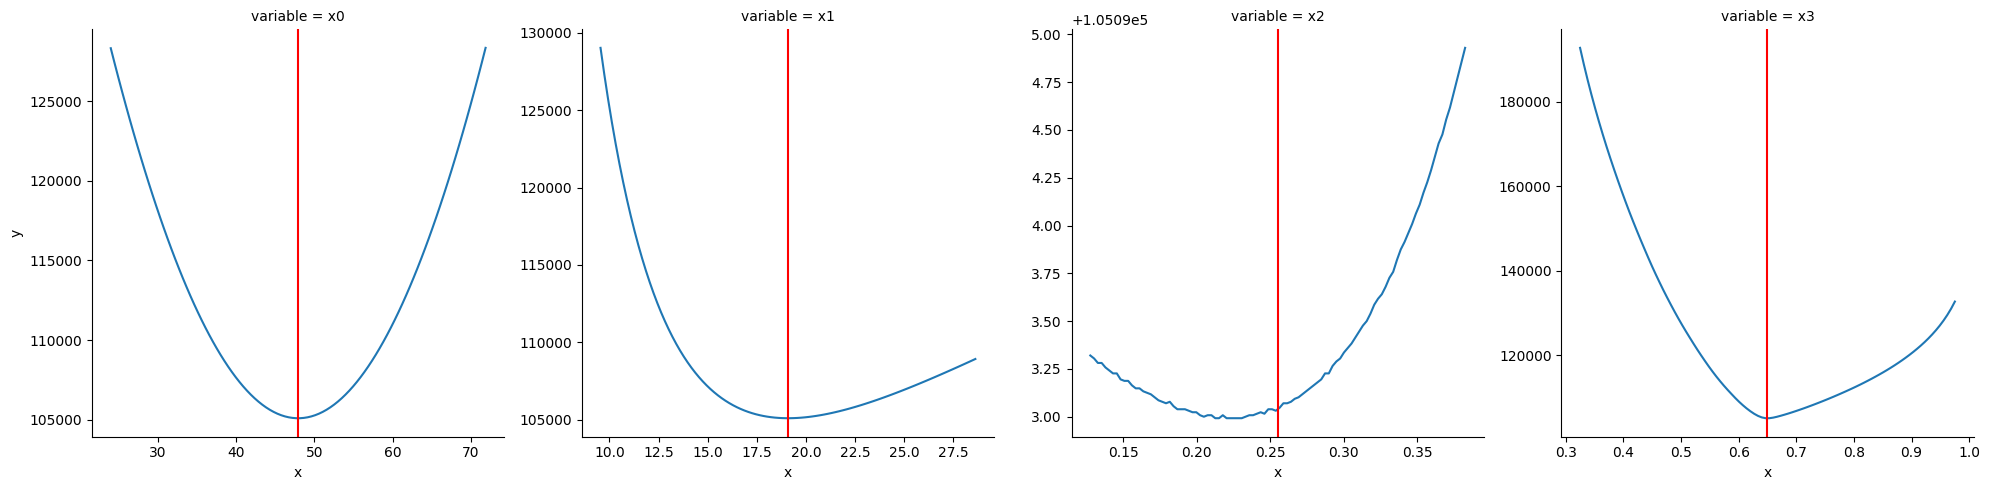

In [158]:
xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    opt_vlines=True
)

# real data

In [162]:
import pandas
import numpy as np

realdata = pandas.read_csv("bending-pl.csv", header = None)
realdata[0] = realdata[0]/1000*6.895

l = 4500/1000*6.895
# R100id = (realdata[1] == "R100")
# R100 = jnp.array(realdata[realdata[1] == "R100"][0])


R100 = jnp.array(realdata[realdata[1] == "R100"][0])
R20 = jnp.array(realdata[realdata[1] == "R20"][0])
R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])

g2 = 97



s= 2
l = l
R100 = R100
R20 = R20
R20R100 = R20R100
g2 = 97
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    #alpha = jnp.exp(theta[2])
    c = theta[3]
    #s = theta[4]
    #s = jnp.exp(theta[4])
    #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(R20,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik2 = g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3- lik4)

#theta0 = jnp.array([mu,sigma,jnp.log(alpha),c,jnp.log(s)])

theta0 = jnp.array([mu,sigma,alpha,c])

negdmglik_jax(theta0)

Array(1685.2568, dtype=float32)

In [163]:
# solver = jaxopt.LBFGS(fun=negdmglik_jax)
# res = solver.run(theta0)



solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax, maxiter =1000)
res = solver.run(theta0)

res.params
theta0

# Array(1678.6377, dtype=float32)
negdmglik_jax(res.params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Array([47.611652  , 18.328579  ,  0.26417983,  0.67030275], dtype=float32)

Array([48.  , 19.  ,  0.25,  0.65], dtype=float32)

Array(1683.532, dtype=float32)

Array([[23.805826  , 71.41748   ],
       [ 9.164289  , 27.492868  ],
       [ 0.13208991,  0.39626974],
       [ 0.33515137,  1.0054541 ]], dtype=float32)

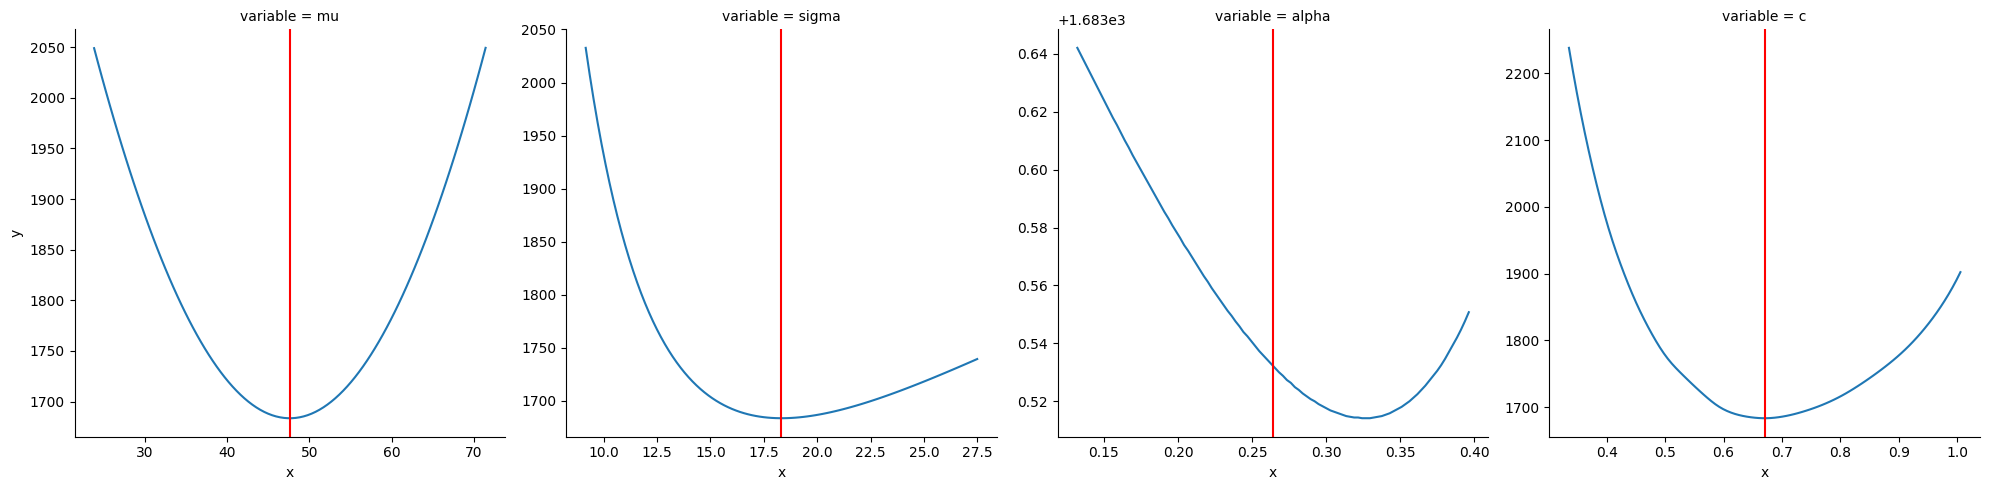

In [164]:
xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    x_names = ["mu","sigma","alpha","c"],
    opt_vlines=True
)

## treat s as an estimated parameter

In [466]:
import pandas
import numpy as np

realdata = pandas.read_csv("bending-pl.csv", header = None)
realdata[0] = realdata[0]/1000*6.895

l = 4500/1000*6.895
# R100id = (realdata[1] == "R100")
# R100 = jnp.array(realdata[realdata[1] == "R100"][0])


R100 = jnp.array(realdata[realdata[1] == "R100"][0])
R20 = jnp.array(realdata[realdata[1] == "R20"][0])
R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])

g2 = 97



#s= 1
l = l
R100 = R100
R20 = R20
R20R100 = R20R100
g2 = 97
@jax.jit
def negdmglik_jax_s(theta):
    mu = theta[0]
    sigma = theta[1]
   # alpha = theta[2]
    alpha = jnp.exp(theta[2])
    c = theta[3]
    #s = jnp.exp(theta[4])
    s = theta[4]
    #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(R20,loc = mu, scale = sigma))
    lik2 = g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3- lik4)

theta0 = jnp.array([mu,sigma,jnp.log(alpha),c,s])

#theta0 = jnp.array([mu,sigma,alpha,c,s])

negdmglik_jax_s(theta0)

Array(1685.2568, dtype=float32)

In [467]:
# solver = jaxopt.LBFGS(fun=negdmglik_jax)
# res = solver.run(theta0)



solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax_s, maxiter =1000)
res = solver.run(theta0)

res.params
theta0

# Array(1678.6377, dtype=float32)
negdmglik_jax_s(res.params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Array([47.893238  , 18.325634  , -8.379548  ,  0.67300177,  0.82836425],      dtype=float32)

Array([48.       , 19.       , -1.3862944,  0.65     ,  2.       ],      dtype=float32)

Array(1679.6515, dtype=float32)

Array([[ 23.946619  ,  71.83986   ],
       [  9.162817  ,  27.488451  ],
       [-12.569323  ,  -4.189774  ],
       [  0.33650088,   1.0095026 ],
       [  0.41418213,   1.2425463 ]], dtype=float32)

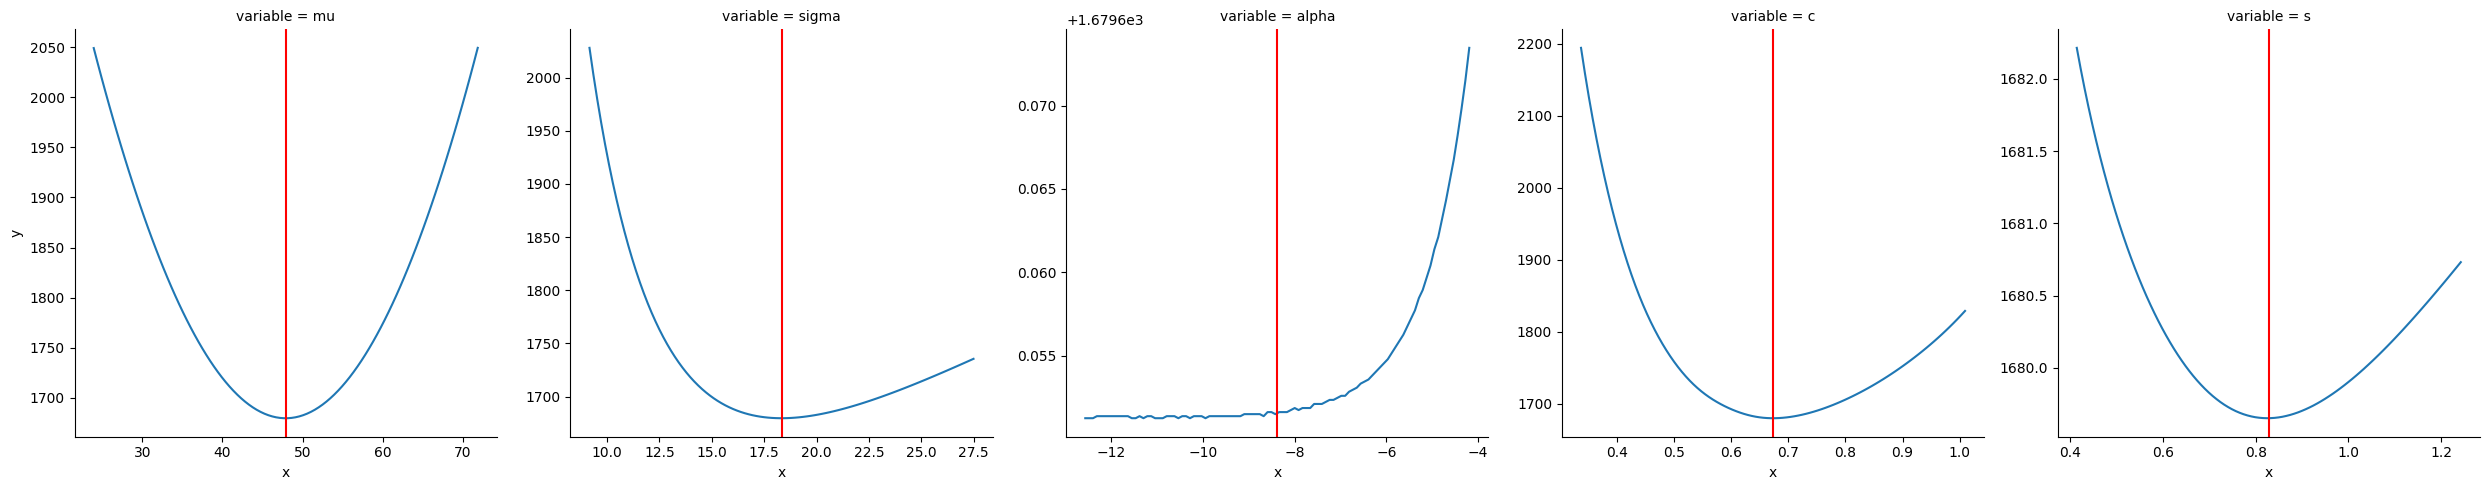

In [468]:
xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax_s,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    x_names = ["mu","sigma","alpha","c","s"],
    opt_vlines=True
)

## damaged y and undamaged ystar

Text(0.5, 0, 'ystar')

Text(0, 0.5, 'y')

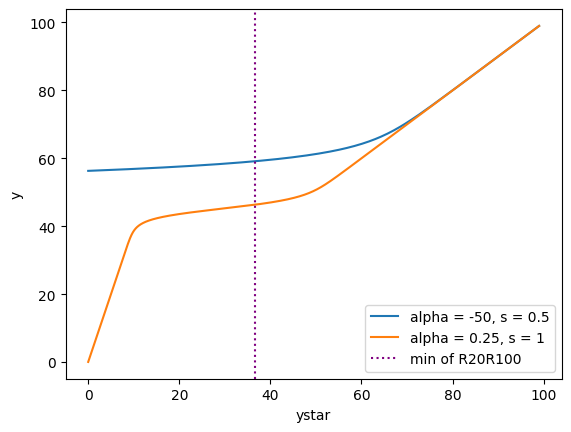

In [445]:
import matplotlib.pyplot as plt
ystar = np.arange(0.01, 99,0.01)

#dmginverse_py
y1 = jax.vmap(lambda ystar:dmginverse_py(ystar,alpha = -50,l = l,c = 0.69,s = 0.5))(ystar)
y2 = jax.vmap(lambda ystar:dmginverse_py(ystar,alpha = 0.25,l = l,c = 0.69,s = 1))(ystar)

plt.plot(ystar, y1, label = "alpha = -50, s = 0.5", linestyle="-")
plt.plot(ystar, y2, label = "alpha = 0.25, s = 1", linestyle="-")
# plt.axvline(x = l/c, 
#            color = 'purple',
#            label = 'damage threshold',linestyle = ":")
plt.axvline(x = min(R20R100), 
           color = 'purple',
           label = 'min of R20R100',linestyle = ":")
plt.xlabel('ystar')
plt.ylabel('y')

plt.legend()
plt.show()

Text(0.5, 0, 'y')

Text(0, 0.5, 'ystar')

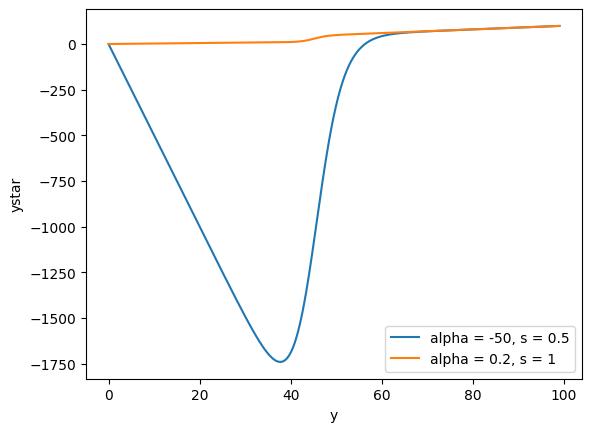

Text(0.5, 0, 'y')

Text(0, 0.5, 'ystar')

(0.0, 100.0)

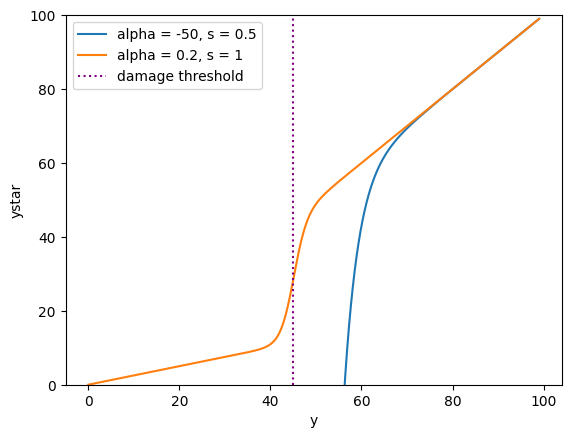

In [460]:
y = np.arange(0.01, 99,0.01)

#dmginverse_py
ystar1 = jax.vmap(lambda y:dmgmodel_py(y,alpha = -50,l = l,c = 0.69,s = 0.5))(y)
ystar2 = jax.vmap(lambda y:dmgmodel_py(y,alpha = 0.25,l = l,c = 0.69,s = 1))(y)

plt.plot(y, ystar1, label = "alpha = -50, s = 0.5", linestyle="-")
plt.plot(y, ystar2, label = "alpha = 0.2, s = 1", linestyle="-")
# # plt.axvline(x = l/c, 
# #            color = 'purple',
# #            label = 'damage threshold',linestyle = ":")
# plt.axvline(x = l/.69, 
#            color = 'purple',
#            label = 'damage threshold',linestyle = ":")
plt.xlabel('y')
plt.ylabel('ystar')

plt.legend()
plt.show()




y = np.arange(0.01, 99,0.01)

#dmginverse_py
ystar1 = jax.vmap(lambda y:dmgmodel_py(y,alpha = -50,l = l,c = 0.69,s = 0.5))(y)
ystar2 = jax.vmap(lambda y:dmgmodel_py(y,alpha = 0.25,l = l,c = 0.69,s = 1))(y)

plt.plot(y, ystar1, label = "alpha = -50, s = 0.5", linestyle="-")
plt.plot(y, ystar2, label = "alpha = 0.2, s = 1", linestyle="-")
# # plt.axvline(x = l/c, 
# #            color = 'purple',
# #            label = 'damage threshold',linestyle = ":")
plt.axvline(x = l/.69, 
           color = 'purple',
           label = 'damage threshold',linestyle = ":")
plt.xlabel('y')
plt.ylabel('ystar')
plt.ylim(0, 100)

plt.legend()
plt.show()


In [357]:

# dmginverse_py(ystar =  50,alpha = 0.2,l = l,c = 0.69,s = 1)
# dmginverse_py(ystar =  50,alpha = -50,l = l,c = 0.69,s = .5)


Array(50.741547, dtype=float32)

Array(61.262726, dtype=float32)

In [364]:
# import pandas
# import numpy as np

# realdata = pandas.read_csv("bending-pl.csv", header = None)
# realdata[0] = realdata[0]/1000*6.895

# l = 4500/1000*6.895
# # R100id = (realdata[1] == "R100")
# # R100 = jnp.array(realdata[realdata[1] == "R100"][0])


# R100 = jnp.array(realdata[realdata[1] == "R100"][0])
# R20 = jnp.array(realdata[realdata[1] == "R20"][0])
# R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])

# g2 = 97



# #s= 1
# l = l
# R100 = R100
# R20 = R20
# R20R100 = R20R100
# g2 = 97
# @jax.jit
# def negdmglik_jax_s(theta):
#     mu = theta[0]
#     sigma = theta[1]
#     alpha = theta[2]
#     alpha = jnp.exp(theta[2])
#     c = theta[3]
#     #s = jnp.exp(theta[4])
#     s = theta[4]
#     #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
#     lik1 = dmglik_vmap(y_group = R20,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik2 = g2*jnp.log(
#         jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
#         jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
#     )
#     lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))

#     return(-lik1 - lik2-lik3- lik4)

# theta0 = jnp.array([mu,sigma,jnp.log(alpha),c,s])

# #theta0 = jnp.array([mu,sigma,alpha,c,s])

# negdmglik_jax_s(theta0)

Array(1682.544, dtype=float32)

In [365]:
# # solver = jaxopt.LBFGS(fun=negdmglik_jax)
# # res = solver.run(theta0)



# solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax_s, maxiter =1000)
# res = solver.run(theta0)

# res.params
# theta0

# # Array(1678.6377, dtype=float32)
# negdmglik_jax_s(res.params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Array([50.452652 , 16.331902 , -0.5077707,  0.6008469,  1.9322915],      dtype=float32)

Array([48.       , 19.       , -0.7985077,  0.65     ,  1.       ],      dtype=float32)

Array(1621.5227, dtype=float32)

Array([[25.226326  , 75.67898   ],
       [ 8.165951  , 24.497852  ],
       [-0.76165605, -0.25388536],
       [ 0.30042344,  0.90127033],
       [ 0.96614575,  2.8984373 ]], dtype=float32)

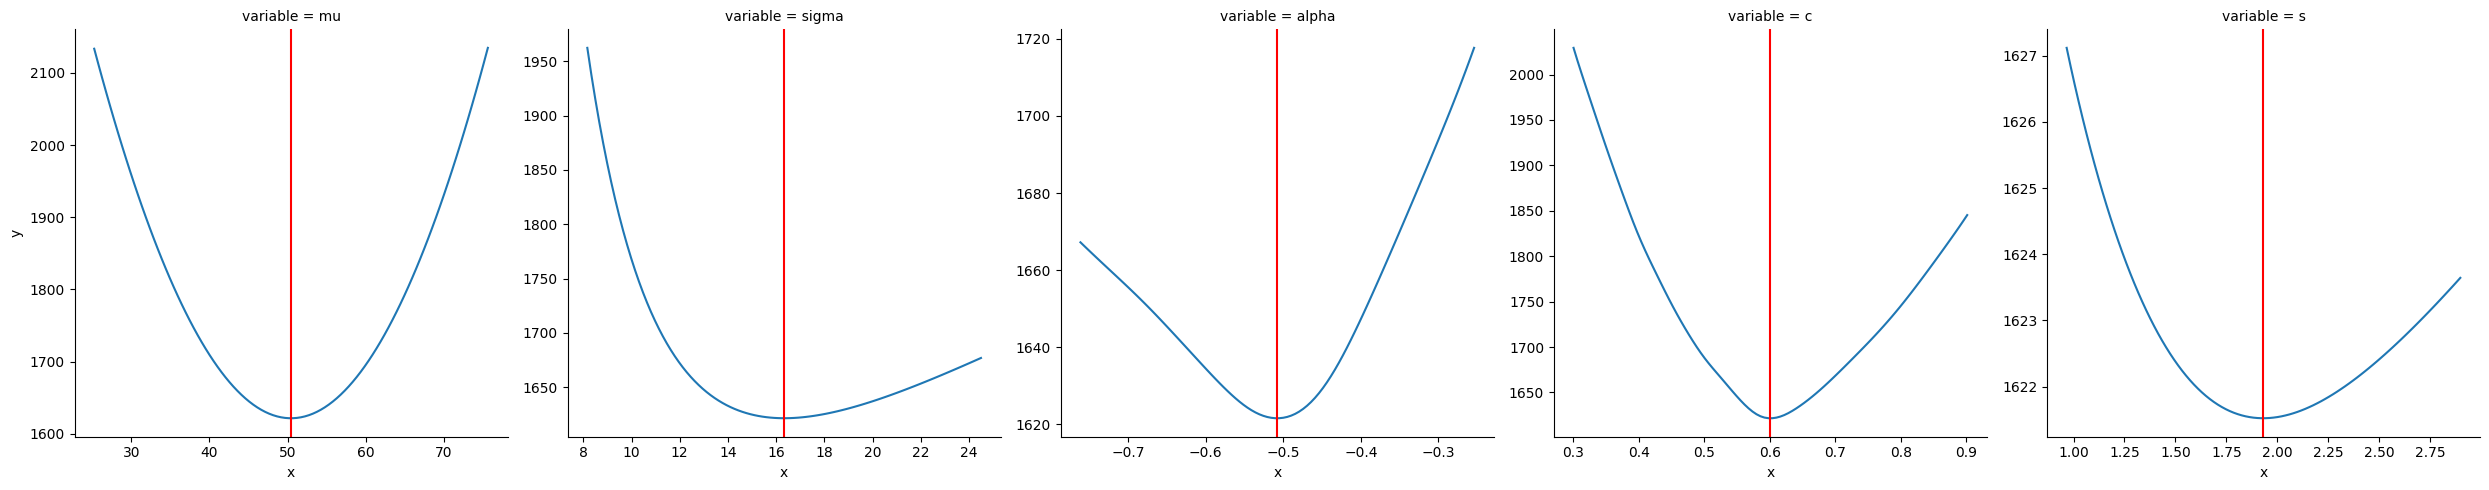

In [366]:
# xsol = res.params
# xrange = .5
# theta_upper = xsol  + xrange *jnp.abs(xsol)
# theta_lower = xsol - xrange * jnp.abs(xsol)
# theta_rng_trans = jnp.array([theta_lower, theta_upper])

# #res.params
# theta_rng = jnp.transpose(theta_rng_trans)
# theta_rng
# # plot at the true value theta0
# pjp.proj_plot(
#     fun=negdmglik_jax_s,
#     x_opt=xsol,
#     x_lims=theta_rng, 
#     n_pts=100, 
#     x_names = ["mu","sigma","alpha","c","s"],
#     opt_vlines=True
# )

# prediction check

In [476]:
import pandas
import numpy as np

realdata = pandas.read_csv("bending-pl.csv", header = None)
realdata[0] = realdata[0]/1000*6.895

l = 4500/1000*6.895
# R100id = (realdata[1] == "R100")
# R100 = jnp.array(realdata[realdata[1] == "R100"][0])


R100 = jnp.array(realdata[realdata[1] == "R100"][0])
R20 = jnp.array(realdata[realdata[1] == "R20"][0])
R20R100 = jnp.array(realdata[realdata[1] == "R20R100"][0])

g2 = 97



#s= 1
l = l
R100 = R100
R20 = R20
R20R100 = R20R100
g2 = 97
@jax.jit
def negdmglik_jax_s(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    #alpha = jnp.exp(theta[2])
    c = theta[3]
    #s = jnp.exp(theta[4])
    s = theta[4]
    #lik1 = jnp.sum(jnp.log(jax.vmap(lambda y: jax.scipy.stats.norm.pdf(y,loc = mu, scale = sigma))(y_obs_g1)))
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(R20,loc = mu, scale = sigma))
    lik2 = g2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = R20R100,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(R100,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3- lik4)

theta0 = jnp.array([mu,sigma,alpha,c,s])

#theta0 = jnp.array([mu,sigma,alpha,c,s])

# solver = jaxopt.LBFGS(fun=negdmglik_jax)
# res = solver.run(theta0)



solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax_s, maxiter =1000)
res = solver.run(theta0)

res.params, res.state
theta0

# Array(1678.6377, dtype=float32)
negdmglik_jax_s(res.params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([ 47.957813 ,  18.329386 , -37.979145 ,   0.8445549,   0.5184274],      dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(1678.642, dtype=float32), success=True, status=0, iter_num=375))

Array([48.  , 19.  ,  0.25,  0.65,  2.  ], dtype=float32)

Array(1678.642, dtype=float32)

Array([[ 23.978907  ,  71.93672   ],
       [  9.164693  ,  27.49408   ],
       [-56.96872   , -18.989573  ],
       [  0.42227745,   1.2668324 ],
       [  0.2592137 ,   0.77764106]], dtype=float32)

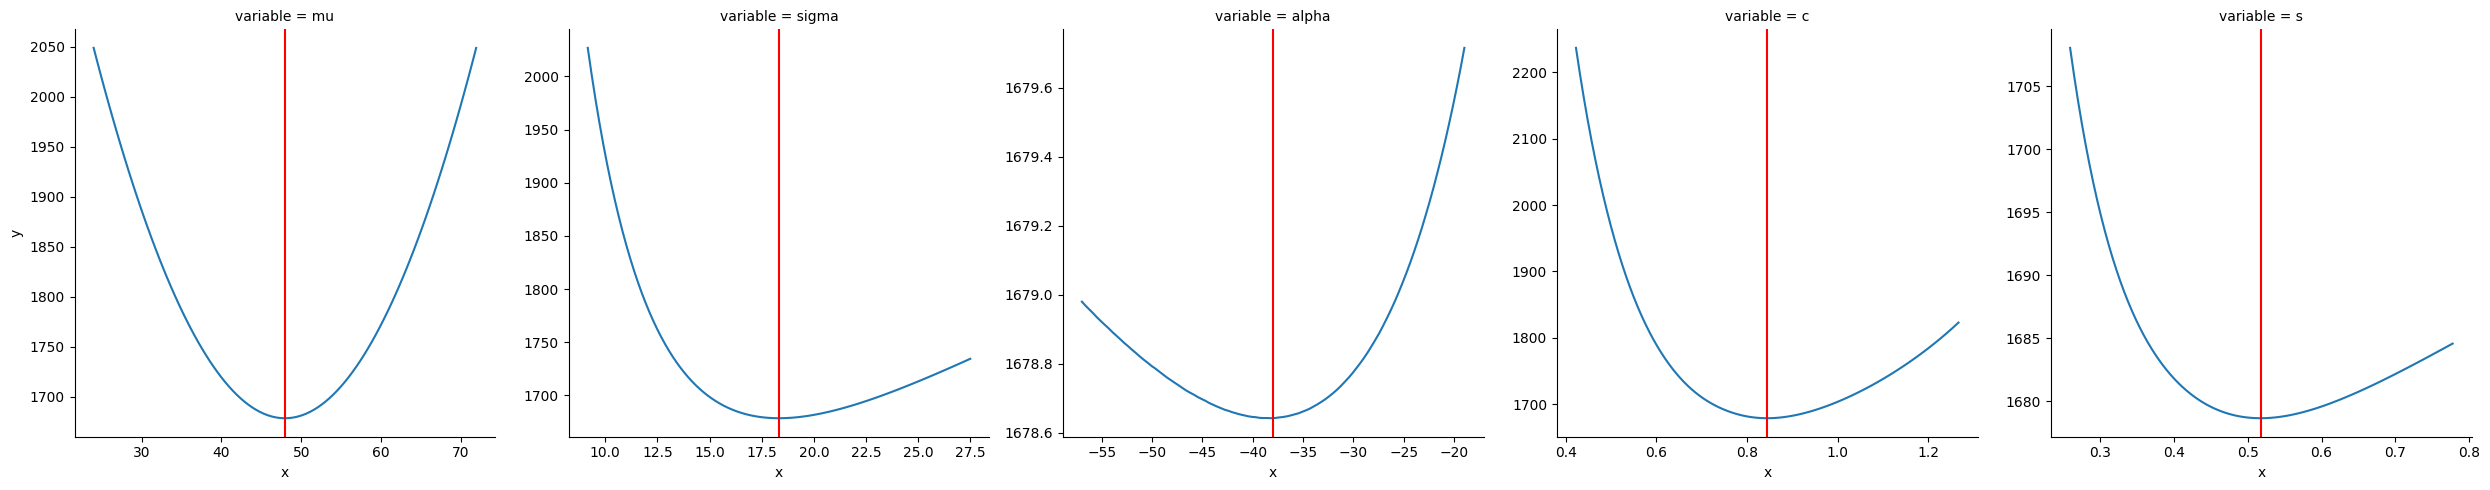

In [477]:
xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax_s,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    x_names = ["mu","sigma","alpha","c","s"],
    opt_vlines=True
)

/var/folders/0x/z947m7157nn9jf8zfnx8w9zw0000gn/T/ipykernel_66207/1619540106.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(R20R100, hist = False)


<Axes: ylabel='Density'>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


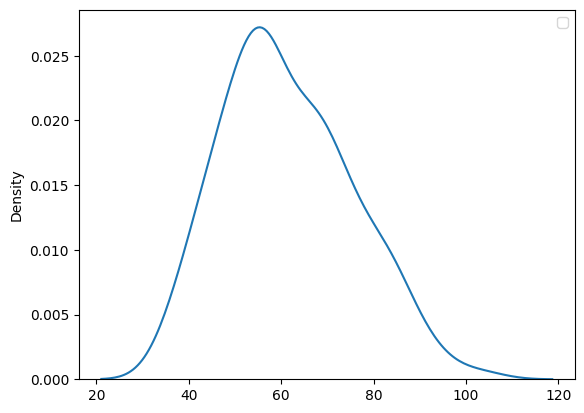

In [486]:
import seaborn as sns

sns.distplot(R20R100, hist = False")
plt.legend(prop="real data")


In [500]:
# data generation 
key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(key, num=N)



# first 
y = res.params[1]*jax.random.normal(subkeys[0], shape=(N, )) + res.params[0]

y = y[y>0]

l = 4500/1000*6.895



# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,res.params[2],l,res.params[3],res.params[4]))(g23)


# g3
y_obs_g3_1 = g23_star[g23_star > l]


# second 




y = res.params[1]*jax.random.normal(subkeys[1], shape=(N, )) + res.params[0]

y = y[y>0]

l = 4500/1000*6.895



# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,res.params[2],l,res.params[3],res.params[4]))(g23)


# g3
y_obs_g3_2 = g23_star[g23_star > l]



# third 
y = res.params[1]*jax.random.normal(subkeys[2], shape=(N, )) + res.params[0]

y = y[y>0]

l = 4500/1000*6.895



# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,res.params[2],l,res.params[3],res.params[4]))(g23)


# g3
y_obs_g3_3 = g23_star[g23_star > l]


# fourth
y = res.params[1]*jax.random.normal(subkeys[3], shape=(N, )) + res.params[0]

y = y[y>0]

l = 4500/1000*6.895



# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,res.params[2],l,res.params[3],res.params[4]))(g23)


# g3
y_obs_g3_4 = g23_star[g23_star > l]

/var/folders/0x/z947m7157nn9jf8zfnx8w9zw0000gn/T/ipykernel_66207/921397701.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(R20R100, hist = False, label = "real data")


<Axes: ylabel='Density'>

/var/folders/0x/z947m7157nn9jf8zfnx8w9zw0000gn/T/ipykernel_66207/921397701.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_obs_g3_1, hist = False, label =" simulated data 1",kde_kws={'linestyle':'--'})


<Axes: ylabel='Density'>

/var/folders/0x/z947m7157nn9jf8zfnx8w9zw0000gn/T/ipykernel_66207/921397701.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_obs_g3_2, hist = False, label =" simulated data 2",kde_kws={'linestyle':'--'})


<Axes: ylabel='Density'>

/var/folders/0x/z947m7157nn9jf8zfnx8w9zw0000gn/T/ipykernel_66207/921397701.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_obs_g3_3, hist = False, label =" simulated data 3",kde_kws={'linestyle':'--'})


<Axes: ylabel='Density'>

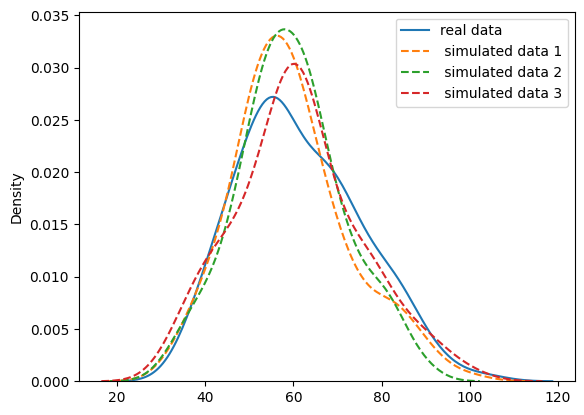

In [502]:
import seaborn as sns

sns.distplot(R20R100, hist = False, label = "real data")

sns.distplot(y_obs_g3_1, hist = False, label =" simulated data 1",kde_kws={'linestyle':'--'})
sns.distplot(y_obs_g3_2, hist = False, label =" simulated data 2",kde_kws={'linestyle':'--'})
sns.distplot(y_obs_g3_3, hist = False, label =" simulated data 3",kde_kws={'linestyle':'--'})

plt.legend()
